In [ ]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

In [ ]:
def disorg(image, blockSize):
    imageSize = image.shape
    rows = imageSize[0] // blockSize
    cols = imageSize[1] // blockSize
    partsNum = rows * cols

    image = image[:rows * blockSize, :cols * blockSize, :]
    rgbPartsArray = np.zeros([blockSize, blockSize, 3, partsNum], dtype=image.dtype)

    for i in range(partsNum):
        rowStartIndex = (i // cols) * blockSize
        rowEndIndex = rowStartIndex + blockSize
        colStartIndex = (i % cols) * blockSize
        colEndIndex = colStartIndex + blockSize

        rgbPartsArray[:, :, :, i] = image[rowStartIndex:rowEndIndex, colStartIndex:colEndIndex, :]

    partsOrder = np.random.permutation(partsNum)
    imageBlocks = rgbPartsArray[:, :, :, partsOrder]

    return imageBlocks, rows, cols

In [ ]:
def MGC(imageblocks):
    blksize = imageblocks.shape[0]
    n = imageblocks.shape[3]
    D = np.zeros((n, n, 4))

    B = 1e-6 * np.array([[0, 0, 1], [1, 1, 1], [1, 0, 0]])
    B = np.tile(B[:, :, np.newaxis], n)

    for o in range(1, 5):
        blk = np.rot90(imageblocks, o - 2, (0, 1))
        GiL = blk[:, blksize-1, :, :] - blk[:, blksize-2, :, :]
        GiL = np.vstack((GiL, B))
        muiL = np.mean(GiL, axis=0)
        invSiL = np.zeros((3, 3, n))

        for k in range(n):
            SiL = np.dot((GiL[:, :, k] - muiL[:, k]).T, (GiL[:, :, k] - muiL[:, k]))
            invSiL[:, :, k] = np.linalg.inv(SiL)

        for i in range(n):
            GijLR = blk[:, 0, :, :] - (blk[:, blksize-1, :, i])[:, :, np.newaxis]
            for j in range(n):
                temp = GijLR[:, :, j] - muiL[:, i]
                D[i, j, o - 1] = np.trace(np.dot(temp, np.dot(invSiL[:, :, i], temp.T)))

    Dtemp = D.copy()
    D[:, :, 0] = (Dtemp[:, :, 0] + Dtemp[:, :, 2].T) / 2
    D[:, :, 1] = (Dtemp[:, :, 1] + Dtemp[:, :, 3].T) / 2
    D[:, :, 2] = D[:, :, 0].T
    D[:, :, 3] = D[:, :, 1].T

    return D

In [ ]:
def MGC2A(D, M, N):
    n = M * N
    DH = (D[:, :, 1] + D[:, :, 3].T) / 2
    DHsort = np.sort(DH, axis=1)
    iH = np.argsort(DH, axis=1)
    qH = DHsort[:, (n // 4) - 1]
    phiH = np.argsort(iH, axis=1)
    CH = np.exp(-(phiH+1) * 2 - DH / qH[:, np.newaxis])
    CH[CH < 1e-6] = 0


    DV = (D[:, :, 2] + D[:, :, 0].T) / 2
    DVsort = np.sort(DV, axis=1)
    iV = np.argsort(DV, axis=1)
    qV = DVsort[:, (n // 4) - 1]
    phiV = np.argsort(iV, axis=1)
    CV = np.exp(-(phiV+1) * 2 - DV / qV[:, np.newaxis])
    CV[CV < 1e-6] = 0

    blockind = np.arange(1, M * N + 1).reshape(M, N)
    A = np.zeros((n ** 2, n ** 2))

    for i in range(M):
        for j in range(N - 1):
            indrow = blockind[i, j]
            indcol = blockind[i, j + 1]
            A[n * (indrow - 1):n * indrow, n * (indcol - 1): n * indcol] = CH

    for i in range(N):
        for j in range(M - 1):
            indrow = blockind[j, i]
            indcol = blockind[j + 1, i]
            A[n * (indrow - 1):n * indrow, n * (indcol - 1): n * indcol] = CV

    A = A + A.T
    return A

In [ ]:
def P2xy(P, M, N):
    blockind = np.arange(1, M * N + 1).reshape(M, N)
    n = M * N
    x = np.zeros(n)
    y = np.zeros(n)

    for i in range(n):
        ind = np.argmax(P[i, :])
        y[i], x[i] = np.where(blockind == ind + 1)

    return x + 1, y + 1

In [ ]:
def jointblocks(imageblocks, x, y):
    blocksize = imageblocks.shape[0]
    n = imageblocks.shape[3]

    x = x - np.min(x)
    x = np.round(x).astype(int)
    y = y - np.min(y)
    y = np.round(y).astype(int)

    jointimage = np.ones(((np.max(y) + 1) * blocksize, (np.max(x) + 1) * blocksize, 3), dtype=imageblocks.dtype)

    for k in range(n):
        rangecol = slice(blocksize * x[k], blocksize * (x[k] + 1))
        rangerow = slice(blocksize * y[k], blocksize * (y[k] + 1))
        jointimage[rangerow, rangecol, :] = imageblocks[:, :, :, k]

    plt.figure()
    plt.imshow(jointimage)
    plt.gca().set_axis_off()
    # plt.show()

    x = x + 1
    y = y + 1

    return jointimage, x, y

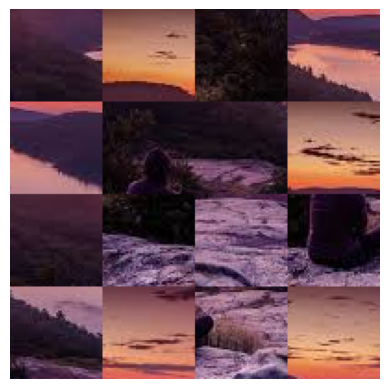

Final solution


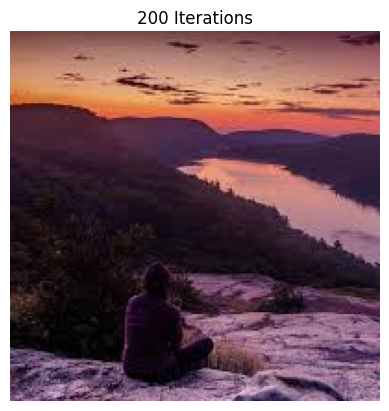

In [ ]:
# Load images
photo = []
photo.append(plt.imread('./jigsaw2.jpeg'))

# Loop over images
for casenum in range(len(photo)):
    image = photo[casenum]
    blocksize = 50
    image = image.astype(np.float64) / 255.0  # Normalize to [0, 1]
    imageblocks, M, N = disorg(image, blocksize)
    n = M * N
    x1, y1 = np.meshgrid(np.arange(1, N + 1), np.arange(1, M + 1))
    puzzleimage = jointblocks(imageblocks, x1.flatten(), y1.flatten())
    plt.show()

    D = MGC(imageblocks)
    A = MGC2A(D, M, N)
    p = np.ones(n ** 2) / n
    Active = np.ones(n ** 2, dtype=bool)
    Aeq1 = np.equal(np.arange(1, n + 1)[:, np.newaxis], np.repeat(np.arange(1, n + 1), n)).astype(int)
    Aeq2 = np.equal(np.arange(1, n + 1)[:, np.newaxis], np.tile(np.arange(1, n + 1), n)).astype(int)
    Aeq = np.concatenate((Aeq1, Aeq2), axis=0)
    Aeq = np.delete(Aeq, -1, axis=0)
    Aineq = np.eye(n ** 2)

    max_iter = 500
    iternum = 0

    while iternum < max_iter:
        iternum += 1

        d = A @ p
        MT = np.concatenate((Aineq[p < 1e-5, :], Aeq), axis=0)
        if np.linalg.det(MT @ MT.T) == 0:
            break
        K = np.eye(n ** 2) - MT.T @ np.linalg.inv(MT @ MT.T) @ MT
        s = K @ d
        s[s == 0] = 1e-12

        t = (1 - p) / (s) * (s >= 0).astype(float) - p / s * (s < 0).astype(float)
        step = np.min(t[Active])
        p = p + step * s * Active
        Active[t == step] = False

print('Final solution')
# Continue button
# plt.figure()
# plt.gca().set_axis_off()
# stop_button = plt.Button(label='Continue')
# stop_button.on_clicked(plt.close)
# plt.show()

P = p.reshape((n, n), order='F')
x, y = P2xy(P, M, N)
jointimage = jointblocks(imageblocks, x, y)
plt.title(f'{iternum} Iterations')
plt.draw()